# Эксперимент с улучшением качества классификации облаков точек с помощью HyperMixer (кол-во точек - 1000)

## Загрузим все нужные библиотеки и импортируем всё нужное:

In [1]:
!pip install --upgrade Cython
!pip install --upgrade Ripser
!pip install --upgrade persim
!pip install --upgrade diagram2vec
!pip install --upgrade ripserplusplus

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 26.2 MB/s eta 0:00:00
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.34
    Uninstalling Cython-0.29.34:
      Successfully uninstalled Cython-0.29.34
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 3.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for Ripser: filename=ripser-0.6.4-cp310-cp310-linux_x86_64.whl size=687058 sha256=c5ac6c5f03c8b8a04c67e42782efd67803c51bcf676dcfececfb0dc7eae84d46
  Stored in directory: /root/.cache/pip/wheels/c5/f5/66/f41f708b04

In [2]:
import numpy as np
import torch.nn.functional as F
import math,copy,re
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import torchtext
import matplotlib.pyplot as plt
import random, math
from typing import Optional
import torch
from torch import nn
from torch.nn import Linear, ReLU, GELU
from tqdm import tqdm
from ripser import lower_star_img
from ripser import Rips
vr = Rips()
import persim
import diagram2vec
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import ripserplusplus as rpp_py
warnings.simplefilter("ignore")
print(torch.__version__)

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
2.0.1+cu118


## Определим модели, которые будем друг с другом сравнивать, и их слои:

In [4]:
class MLP(torch.nn.Module):
    
    def __init__(self, n_in, n_hidden, n_out):
        super().__init__()
        self.linear1 = Linear(n_in, n_hidden)
        self.linear2 = Linear(n_hidden, n_out)
        
    def forward(self, x):
        return self.linear2(ReLU()(self.linear1(x)))

class HyperMixerMLP(torch.nn.Module):
    def __init__(self, n_in, n_hidden, n_out=None, mlps=1):
        super().__init__()
        if n_out is None:
            n_out = n_in

        self.original_in_size = n_in
        self.original_out_size = n_out

        assert n_in % mlps == 0
        assert n_out % mlps == 0
        assert n_hidden % mlps == 0
        n_in = n_in // mlps
        n_out = n_out // mlps
        n_hidden = n_hidden // mlps

        self.input_size = n_in
        self.output_size = n_out

        self.num_mlps = mlps

        self.fc1_weights = torch.nn.Parameter(torch.empty(mlps, n_hidden, n_in))
        self.fc1_biases = torch.nn.Parameter(torch.empty(mlps, n_hidden))
        self.fc2_weights = torch.nn.Parameter(torch.empty(mlps, n_out, n_hidden))
        self.fc2_biases = torch.nn.Parameter(torch.empty(mlps, n_out))

        torch.nn.init.xavier_uniform_(self.fc1_weights, gain=math.sqrt(2.0))
        torch.nn.init.xavier_uniform_(self.fc1_biases, gain=math.sqrt(2.0))
        torch.nn.init.xavier_uniform_(self.fc2_weights, gain=math.sqrt(2.0))
        torch.nn.init.xavier_uniform_(self.fc2_biases, gain=math.sqrt(2.0))

        self.activation = torch.nn.GELU()
    
    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)

        x = x.reshape((batch_size, seq_len, self.num_mlps, self.output_size))
        x = torch.einsum("blmf,mhf->bmlh", x, self.fc1_weights) + self.fc1_biases.unsqueeze(0).unsqueeze(2)
        x = self.activation(x)
        x = torch.einsum("bmlh,mfh->bmlf", x, self.fc2_weights) + self.fc2_biases.unsqueeze(0).unsqueeze(2)

        return x
    
class HyperNetwork(torch.nn.Module):
    
    def __init__(self, d_in, d_hidden, n_in, n_hidden, mlps=1, tied=False):
        super().__init__()
        self.tied = tied
        self.w1_gen = HyperMixerMLP(n_in, n_hidden, n_in, mlps)
        if self.tied:
            self.w2_gen = self.w1_gen
        else:
            self.w2_gen = HyperMixerMLP(d_in, d_hidden, d_in, mlps)
        
    def forward(self, x):
        W1 = self.w1_gen(x.transpose(1, 2))
        if self.tied:
            W2 = W1
        else:
            W2 = self.w2_gen(x)
        return W1, W2

class HyperMixer(torch.nn.Module):
    def __init__(self, d_in, d_hidden, n_in, n_hidden, mlps=1, tied=False):
        super().__init__()
        self.input_dim = n_in
        self.output_dim = d_in
        self.hyper = HyperNetwork(d_in, d_hidden, n_in, n_hidden, mlps, tied)
        self.activation = torch.nn.GELU()
        self.layer_norm = torch.nn.LayerNorm(d_in)
        self.num_heads = mlps

    def forward(self, x):
        out = x
        batch_size = out.size(0)
        seq_len = out.size(1)
        hyp_input = out
        W1, W2 = self.hyper(hyp_input)

        out = out.transpose(1, 2)
        out = out.reshape((batch_size * self.num_heads, 
                           self.output_dim // self.num_heads, seq_len)) 
        W1 = W1.reshape((batch_size * self.num_heads, seq_len, -1))
        W2 = W2.reshape((batch_size * self.num_heads, seq_len, -1))

        out = self.activation(torch.bmm(out, W1))
        out = torch.bmm(out, W2.transpose(1, 2))

        out = out.reshape((batch_size, self.output_dim, seq_len))

        out = self.layer_norm(out.transpose(1, 2))

        return out

In [5]:
class MLP(torch.nn.Module):
    def __init__(self, n_in, n_hidden, n_out):
        super(MLP, self).__init__()
        self.linear1 = Linear(n_in, n_hidden)
        self.linear2 = Linear(n_hidden, n_out)
        
    def forward(self, X):
        X = F.relu(self.linear1(X))
        X = self.linear2(X)
        return X
    
class Encoder(torch.nn.Module):
    def __init__(self, n_in, n_hidden, n_out):
        super(Encoder, self).__init__()
        self.mlp = MLP(n_in, n_hidden, n_out)
        
    def forward(self, X):
        X = self.mlp(X)
        return X

class DeepSets(torch.nn.Module):
    """
      DeepSets model
    """
    def __init__(self, n_in, n_hidden_enc, n_out_enc, n_hidden_dec=16, n_out_dec=2):
        super(DeepSets, self).__init__()
        self.encoder = Encoder(n_in, n_hidden_enc, n_out_enc)
        self.decoder = MLP(n_out_enc, n_hidden_dec, n_out_dec)
        
    def forward(self, X):
        z_enc = self.encoder(X).mean(dim=1)
        z = self.decoder(z_enc)
        return z

class LightHyperClassifier(torch.nn.Module):
    """
      DeepSets with a HyperMixer block as token mixing layer
    """
    def __init__(self, n_in, n_hidden_enc, n_out_enc, 
                 n_hidden_dec=16, n_out_dec=2, input_size=1024):
        super(LightHyperClassifier, self).__init__()
        self.encoder = Encoder(n_in, n_hidden_enc, n_out_enc)
        self.token_mixing = HyperMixer(n_out_enc, 2 * n_hidden_enc, input_size, 
                                       2 * n_hidden_enc, mlps=4)
        self.decoder = MLP(n_out_enc, n_hidden_dec, n_out_dec)
        
    def forward(self, X):
        z_enc = self.encoder(X)
        z_mixed = self.token_mixing(z_enc)
        z = self.decoder(z_enc)
        return z.mean(dim=1)

## Генерация датасета:

In [9]:
def generate_orbit(point_0, r, n=300):
    
    X = np.zeros([n, 2])
    
    xcur, ycur = point_0[0], point_0[1]
    
    for idx in range(n):
        xcur = (xcur + r * ycur * (1. - ycur)) % 1
        ycur = (ycur + r * xcur * (1. - xcur)) % 1
        X[idx, :] = [xcur, ycur]
    
    return X

def generate_orbits(m, rs=[2.5, 3.5, 4.0, 4.1, 4.3], n=300, random_state=None):
    
    # m orbits, each of n points of dimension 2
    orbits = np.zeros((m * len(rs), n, 2))
    
    # for each r
    for j, r in enumerate(rs):

        # initial points
        points_0 = random_state.uniform(size=(m,2))

        for i, point_0 in enumerate(points_0):
            orbits[j*m + i] = generate_orbit(points_0[i], rs[j], n=n)
            
    return orbits

In [10]:
random_state = np.random.RandomState(42)
X_orbit5k = generate_orbits(1000, random_state=random_state, n=1000)

In [11]:
X_pc = np.concatenate((X_orbit5k[2000:3000], X_orbit5k[4000:5000]))
y = np.concatenate((np.zeros(1000), np.ones(1000)))

In [12]:
def conv_pd(diagrams):
    pd = np.zeros((0, 3))

    for k, diagram_k in enumerate(diagrams):
        diagram_k = diagram_k[~np.isinf(diagram_k).any(axis=1)] # filter infs  
        diagram_k = np.concatenate((diagram_k, k * np.ones((diagram_k.shape[0], 1))), axis=1)
        pd = np.concatenate((pd, diagram_k))

    return pd

In [13]:
X = []

for x_pc in tqdm(X_pc):
    diagram = rpp_py.run("--format point-cloud --dim 1", x_pc)
    diagram = [np.array([[diagram[j][i][0], diagram[j][i][1]] for i in range(len(diagram[j]))]) for j in range(2)]
    # print(np.array(rpp_py.run("--format point-cloud --dim 1", x_pc)[1], dtype=float).shape)
    # print(type(vr.fit_transform(x_pc)[0][0]))
    diagram = conv_pd(diagram)
    # diagram = conv_pd(vr.fit_transform(x_pc))
    X.append(diagram)

100%|██████████| 2000/2000 [12:14<00:00,  2.72it/s]


In [14]:
class Orbit2kDataset(Dataset):
    
    def __init__(self, X, y, transform=None):
        # print(X[0].shape, X[1].shape)
        self.X = nn.utils.rnn.pad_sequence([torch.from_numpy(i) for i in X] + [torch.zeros((2048, 3))],
                                           batch_first=True)[:len(X), :, :]
        self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
def collate_fn(data):
    
    tmp_pd, _ = data[0]
    
    n_batch = len(data)
    n_features_pd = tmp_pd.shape[1]
    n_points_pd = max(len(pd) for pd, _ in data)
    inputs_pd = np.zeros((n_batch, n_points_pd, n_features_pd), dtype=float)
    labels = np.zeros(len(data))
    
    for i, (pd, label) in enumerate(data):
        inputs_pd[i][:len(pd)] = pd
        labels[i] = label
    
    return torch.Tensor(inputs_pd), torch.Tensor(labels).long()

## Непосредственный процесс обучения:

In [16]:
if torch.cuda.is_available(): 
    dev = "cuda:0" 
else: 
    dev = "cpu" 
device = torch.device(dev) 

In [17]:
print(dev)

cuda:0


### Первичный процесс обучения:

In [19]:
%%time
n_repeats = 3
n_epochs = 300
batch_size = 64

embed_dim = 3
input_vocab_size = 3
classes_num = 2

lr_ds = 0.001
lr_hc = 0.001

n_train, n_test = 1600, 400

history = np.zeros((2, n_repeats, n_epochs, 3))
criterion = CrossEntropyLoss()

dataset = Orbit2kDataset(X, y)
seq_length = dataset[0][0].shape[0]

for repeat_idx in range(n_repeats):
    
    # data init
    dataset_train, dataset_test = random_split(dataset, [n_train, n_test])
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    
    # model init
    deep_sets = DeepSets(n_in=embed_dim, n_hidden_enc=16, n_out_enc=8).to(dev)
    hyper_classifier = LightHyperClassifier(n_in=embed_dim, n_hidden_enc=16, 
                                            n_out_enc=8, 
                                            input_size=seq_length).to(dev)
    optimizer_ds = Adam(deep_sets.parameters(), lr=lr_ds)
    optimizer_hc = Adam(hyper_classifier.parameters(), lr=lr_hc)
    
    print("{:3} {:6} {:6} {:6} {:6} {:6} {:6}".format(repeat_idx, "Loss DS", 
                                                      "Train DS", "Test DS", 
                                                      "Loss HC", "Train HC", 
                                                      "Test HC"))
    
    for epoch_idx in range(n_epochs):
        
        # train
        deep_sets.train()
        hyper_classifier.train()
        
        loss_epoch_ds = []
        loss_epoch_hc = []
        for batch in dataloader_train:
            # print(batch[0].shape)
            loss_batch_ds = criterion(deep_sets(batch[0].to(dev)).cpu(), batch[1])
            loss_batch_hc = criterion(hyper_classifier(batch[0].to(dev)).cpu(), 
                                      batch[1])
            loss_batch_ds.backward()
            loss_batch_hc.backward()
            optimizer_ds.step()
            optimizer_hc.step()
            optimizer_ds.zero_grad()
            optimizer_hc.zero_grad()
            loss_epoch_ds.append(loss_batch_ds.detach())
            loss_epoch_hc.append(loss_batch_hc.detach())
        # print("training done", end=' ')
        loss_epoch_ds_mean = np.array(loss_epoch_ds).mean()
        loss_epoch_hc_mean = np.array(loss_epoch_hc).mean()
        history[0,repeat_idx,epoch_idx,0] = loss_epoch_ds_mean
        history[1,repeat_idx,epoch_idx,0] = loss_epoch_hc_mean
        
        # test
        deep_sets.eval()
        hyper_classifier.eval()
        
        correct_ds = 0
        correct_hc = 0
        for batch in dataloader_train:
            y_hat_ds = deep_sets(batch[0].to(dev)).cpu().argmax(dim=1)
            y_hat_hc = hyper_classifier(batch[0].to(dev)).cpu().argmax(dim=1)
            correct_ds += int((y_hat_ds == batch[1]).sum())
            correct_hc += int((y_hat_hc == batch[1]).sum())
        accuracy_train_ds = correct_ds / len(dataloader_train.dataset)
        history[0,repeat_idx,epoch_idx,1] = accuracy_train_ds
        accuracy_train_hc = correct_hc / len(dataloader_train.dataset)
        history[1,repeat_idx,epoch_idx,1] = accuracy_train_hc

        correct_ds = 0
        correct_hc = 0
        for batch in dataloader_test:
            y_hat_ds = deep_sets(batch[0].to(dev)).cpu().argmax(dim=1)
            y_hat_hc = hyper_classifier(batch[0].to(dev)).cpu().argmax(dim=1)
            correct_ds += int((y_hat_ds == batch[1]).sum())
            correct_hc += int((y_hat_hc == batch[1]).sum())
        accuracy_test_ds = correct_ds / len(dataloader_test.dataset)
        history[0,repeat_idx,epoch_idx,2] = accuracy_test_ds
        accuracy_test_hc = correct_hc / len(dataloader_test.dataset)
        history[1,repeat_idx,epoch_idx,2] = accuracy_test_hc
        
        print("{:3} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f}".format(
            epoch_idx, loss_epoch_ds_mean, 
            accuracy_train_ds, 
            accuracy_test_ds,
            loss_epoch_hc_mean, 
            accuracy_train_hc, 
            accuracy_test_hc))
    print("\r")

  0 Loss DS Train DS Test DS Loss HC Train HC Test HC
  0 0.7049 0.4975 0.5100 0.6938 0.4975 0.5100
  1 0.6983 0.4975 0.5100 0.6933 0.5025 0.4900
  2 0.6948 0.4975 0.5100 0.6931 0.5025 0.4900
  3 0.6932 0.5294 0.5100 0.6930 0.5025 0.4900
  4 0.6928 0.5288 0.5075 0.6931 0.5288 0.5050
  5 0.6926 0.5288 0.5050 0.6930 0.5025 0.4900
  6 0.6926 0.5294 0.5125 0.6930 0.5356 0.5275
  7 0.6924 0.5288 0.5050 0.6929 0.5025 0.4900
  8 0.6922 0.5288 0.5075 0.6929 0.5288 0.5050
  9 0.6924 0.5288 0.5050 0.6932 0.5025 0.4900
 10 0.6919 0.6081 0.5925 0.6929 0.4975 0.5100
 11 0.6918 0.5288 0.5100 0.6930 0.5288 0.5075
 12 0.6913 0.5294 0.5100 0.6927 0.5288 0.5075
 13 0.6910 0.5288 0.5075 0.6928 0.5288 0.5050
 14 0.6907 0.5331 0.5150 0.6927 0.4994 0.5100
 15 0.6905 0.5288 0.5075 0.6928 0.5275 0.5025
 16 0.6896 0.5312 0.5125 0.6926 0.5288 0.5050
 17 0.6895 0.5975 0.5850 0.6927 0.4975 0.5100
 18 0.6890 0.5294 0.5125 0.6927 0.5288 0.5050
 19 0.6882 0.5306 0.5125 0.6925 0.5288 0.5050
 20 0.6877 0.5875 0.5725 0

#### Построим сравнительные графики для фукнций потерь и точности обеих моделей:

In [20]:
x_ds = np.arange(n_epochs)
loss_ci1_ds = history[0,:,:,:].mean(axis=0)[:,0] - history[0,:,:,:].std(axis=0)[:,0]
loss_ci2_ds = history[0,:,:,:].mean(axis=0)[:,0] + history[0,:,:,:].std(axis=0)[:,0]
acc_train_ci1_ds = history[0,:,:,:].mean(axis=0)[:,1] - history[0,:,:,:].std(axis=0)[:,1]
acc_train_ci2_ds = history[0,:,:,:].mean(axis=0)[:,1] + history[0,:,:,:].std(axis=0)[:,1]
acc_test_ci1_ds = history[0,:,:,:].mean(axis=0)[:,2] - history[0,:,:,:].std(axis=0)[:,2]
acc_test_ci2_ds = history[0,:,:,:].mean(axis=0)[:,2] + history[0,:,:,:].std(axis=0)[:,2]
x_hc = np.arange(n_epochs)
loss_ci1_hc = history[1,:,:,:].mean(axis=0)[:,0] - history[1,:,:,:].std(axis=0)[:,0]
loss_ci2_hc = history[1,:,:,:].mean(axis=0)[:,0] + history[1,:,:,:].std(axis=0)[:,0]
acc_train_ci1_hc = history[1,:,:,:].mean(axis=0)[:,1] - history[1,:,:,:].std(axis=0)[:,1]
acc_train_ci2_hc = history[1,:,:,:].mean(axis=0)[:,1] + history[1,:,:,:].std(axis=0)[:,1]
acc_test_ci1_hc = history[1,:,:,:].mean(axis=0)[:,2] - history[1,:,:,:].std(axis=0)[:,2]
acc_test_ci2_hc = history[1,:,:,:].mean(axis=0)[:,2] + history[1,:,:,:].std(axis=0)[:,2]

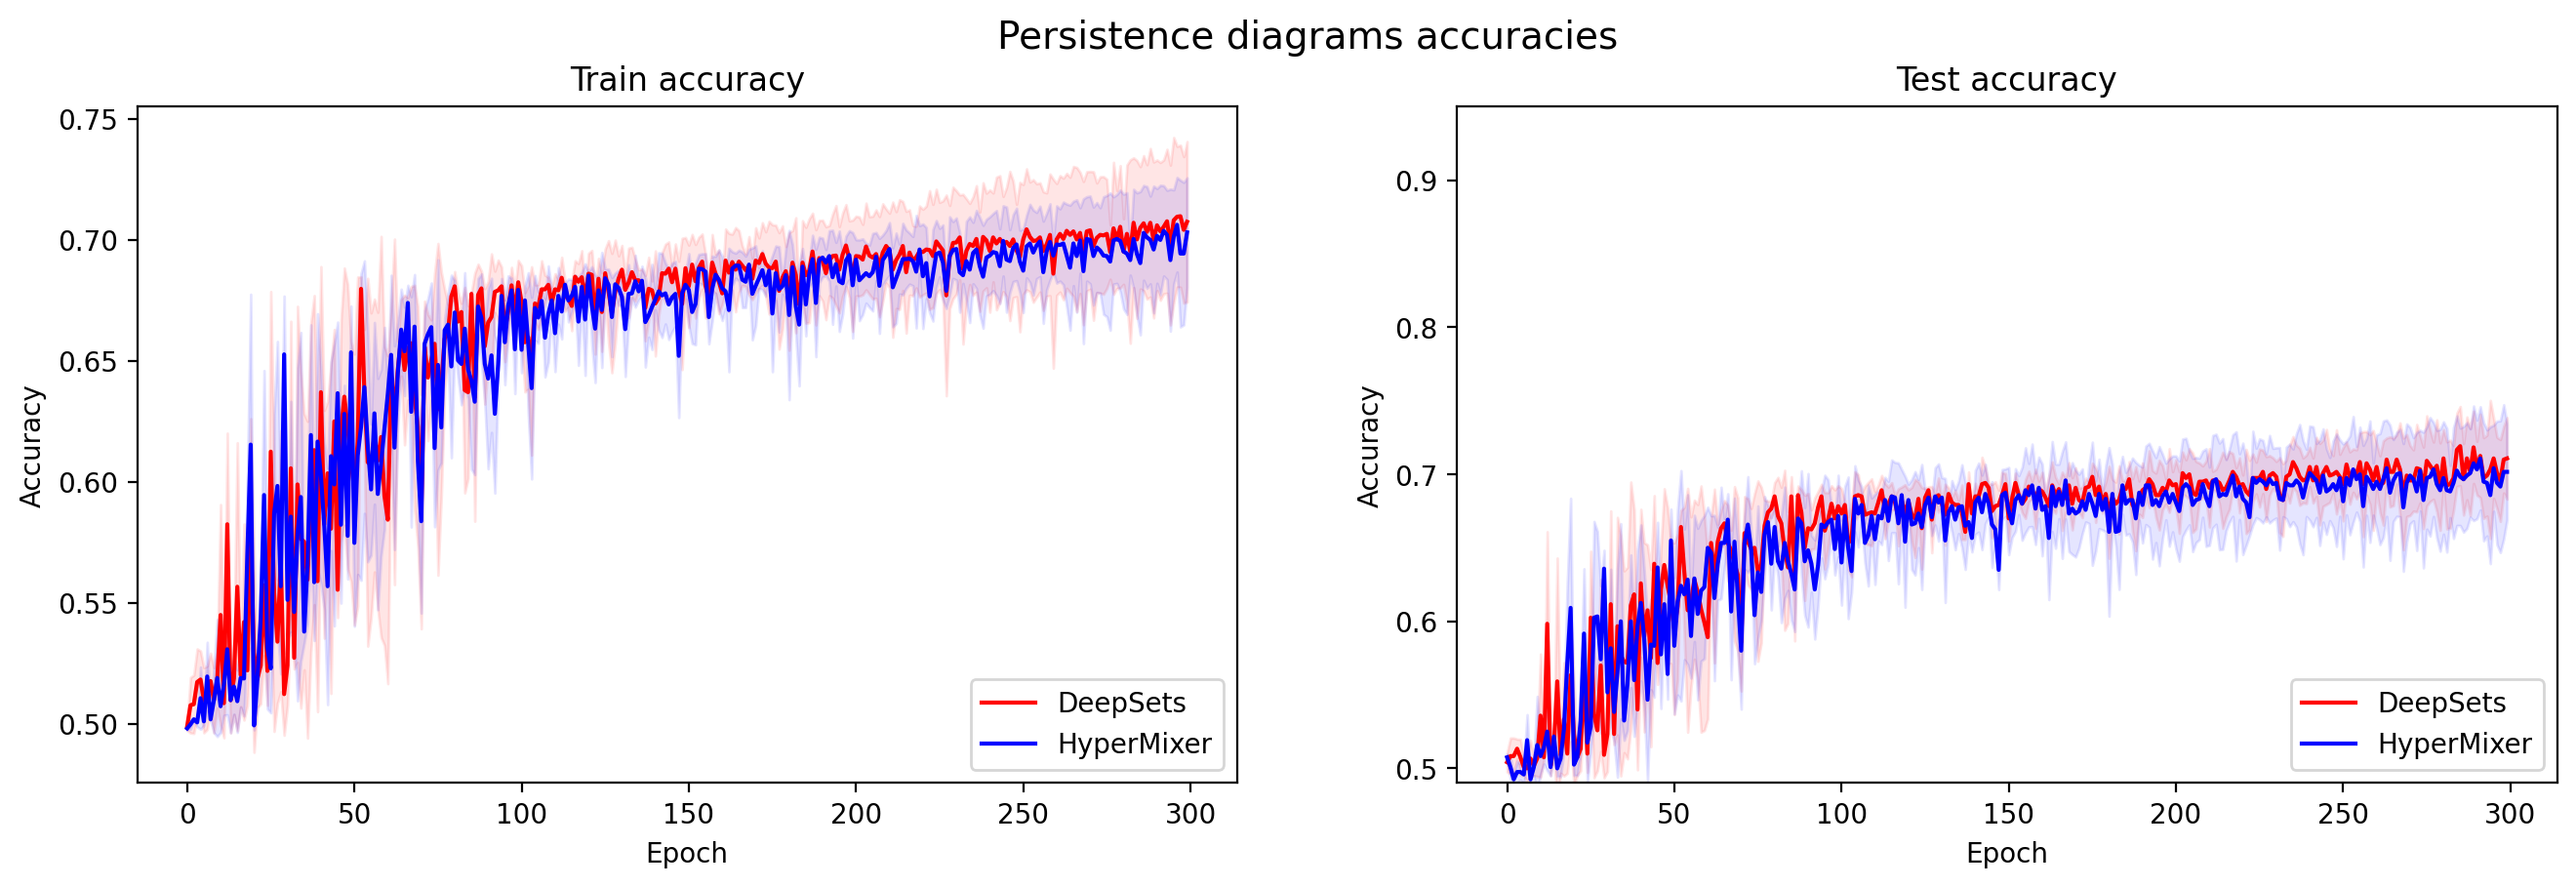

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4.5), dpi=200)
fig.suptitle("Persistence diagrams accuracies", fontsize=14)
ax[0].set_title("Train accuracy")
ax[1].set_ylim(0.49, 0.95)
ax[0].plot(history[0,:,:,:].mean(axis=0)[:,1], c="r", label="DeepSets")
ax[0].plot(history[1,:,:,:].mean(axis=0)[:,1], c="b", label="HyperMixer")
ax[0].fill_between(x_ds, acc_train_ci1_ds, acc_train_ci2_ds, color="r", alpha=0.1)
ax[0].fill_between(x_hc, acc_train_ci1_hc, acc_train_ci2_hc, color="b", alpha=0.1)
ax[0].legend(loc=4)
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[1].set_title("Test accuracy")
ax[1].set_ylim(0.49, 0.95)
ax[1].plot(history[0,:,:,:].mean(axis=0)[:,2], c="r", label="DeepSets")
ax[1].plot(history[1,:,:,:].mean(axis=0)[:,2], c="b", label="HyperMixer")
ax[1].fill_between(x_ds, acc_test_ci1_ds, acc_test_ci2_ds, color="r", alpha=0.1)
ax[1].fill_between(x_hc, acc_test_ci1_hc, acc_test_ci2_hc, color="b", alpha=0.1)
ax[1].legend(loc=4)
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
plt.show()

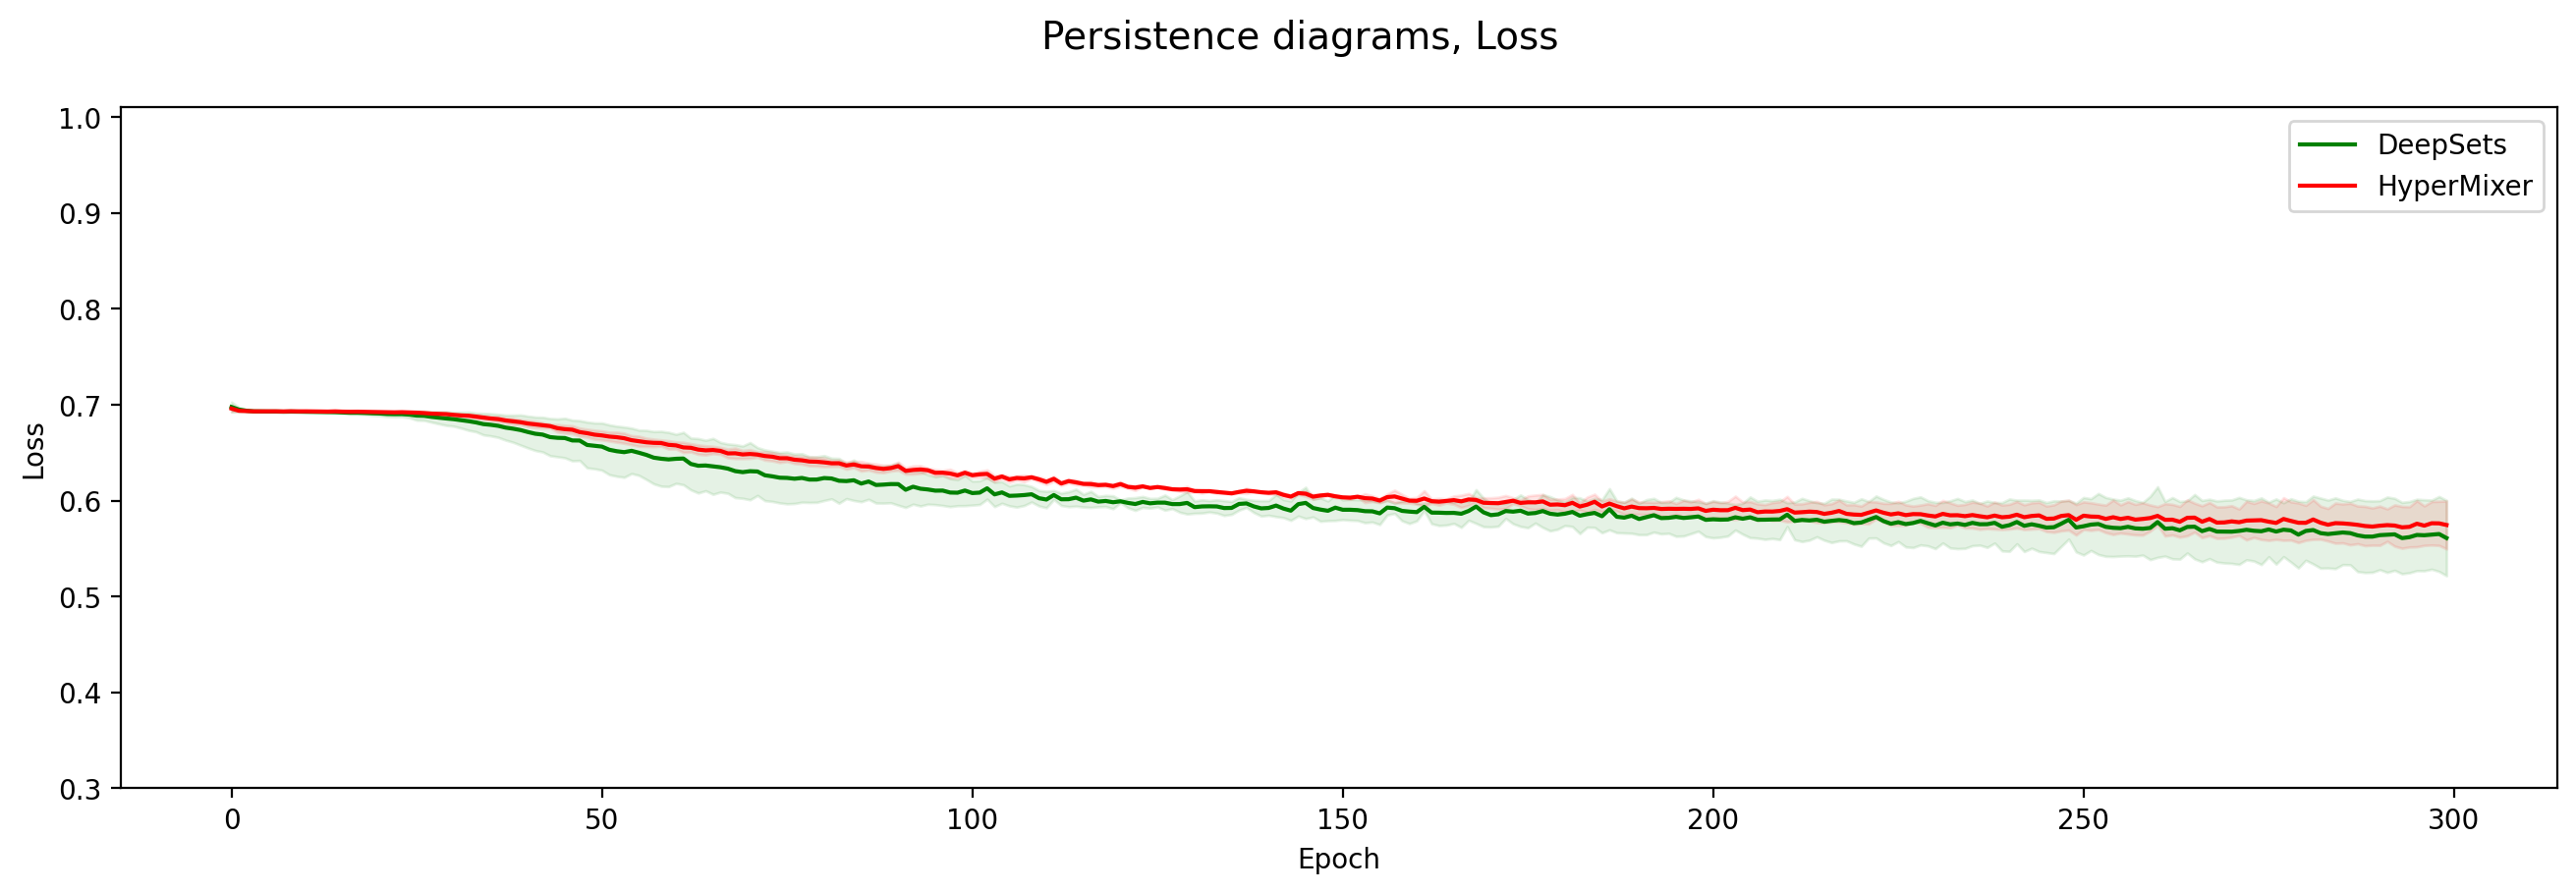

In [22]:
plt.figure(figsize=(16, 4.5), dpi=200)
plt.suptitle("Persistence diagrams, Loss", fontsize=14)
plt.ylim(0.3, 1.01)
plt.plot(history[0,:,:,:].mean(axis=0)[:,0], c="g", label="DeepSets")
plt.fill_between(x_ds, loss_ci1_ds, loss_ci2_ds, color="g", alpha=0.1)
plt.plot(history[1,:,:,:].mean(axis=0)[:,0], c="r", label="HyperMixer")
plt.fill_between(x_hc, loss_ci1_hc, loss_ci2_hc, color="r", alpha=0.1)
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show();

#### Сводная таблица с результатами:

In [23]:
print("\t\t\t\t\tLoss\tTrain\tTest")
print("DeepSets avg results:\t\t\t{:.4f}\t{:.4f}\t{:.4f}".format(*history[0,:,-1,:].mean(axis=0)), sep="\t") # avg loss, avg train acc, avg test acc
print("HyperClassifier avg results:\t\t{:.4f}\t{:.4f}\t{:.4f}".format(*history[1,:,-1,:].mean(axis=0)), sep="\t") # avg loss, avg train acc, avg test acc
print("DeepSets results' std:\t\t\t{:.4f}\t{:.4f}\t{:.4f}".format(*history[0,:,-1,:].std(axis=0)), sep="\t") # avg loss, avg train acc, avg test acc
print("HyperClassifier results' std:\t\t{:.4f}\t{:.4f}\t{:.4f}".format(*history[1,:,-1,:].std(axis=0)), sep="\t") # avg loss, avg train acc, avg test acc
for i in range(3):
    print("DeepSets {} repeat results:\t\t{:.4f}\t{:.4f}\t{:.4f}".format(i+1, *history[0,i,-1,:]), sep="\t")
    print("HyperClassifier {} repeat results:\t{:.4f}\t{:.4f}\t{:.4f}".format(i+1, *history[1,i,-1,:]), sep="\t")

					Loss	Train	Test
DeepSets avg results:			0.5610	0.7075	0.7108
HyperClassifier avg results:		0.5746	0.7031	0.7017
DeepSets results' std:			0.0393	0.0331	0.0277
HyperClassifier results' std:		0.0250	0.0225	0.0326
DeepSets 1 repeat results:		0.5849	0.6844	0.6925
HyperClassifier 1 repeat results:	0.5927	0.6875	0.6825
DeepSets 2 repeat results:		0.5056	0.7544	0.7500
HyperClassifier 2 repeat results:	0.5919	0.6869	0.6750
DeepSets 3 repeat results:		0.5926	0.6837	0.6900
HyperClassifier 3 repeat results:	0.5393	0.7350	0.7475


### Вторичный процесс обучения:

In [24]:
%%time
n_repeats = 5
n_epochs = 800
batch_size = 64

embed_dim = 3
input_vocab_size = 3
classes_num = 2

lr_ds = 0.002
lr_hc = 0.002

n_train, n_test = 1600, 400

history = np.zeros((2, n_repeats, n_epochs, 3))
criterion = CrossEntropyLoss()

dataset = Orbit2kDataset(X, y)
seq_length = dataset[0][0].shape[0]

for repeat_idx in range(n_repeats):
    
    # data init
    dataset_train, dataset_test = random_split(dataset, [n_train, n_test])
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    
    # model init
    deep_sets = DeepSets(n_in=embed_dim, n_hidden_enc=32, n_out_enc=16).to(dev)
    hyper_classifier = LightHyperClassifier(n_in=embed_dim, n_hidden_enc=32, 
                                            n_out_enc=16, 
                                            input_size=seq_length).to(dev)
    optimizer_ds = Adam(deep_sets.parameters(), lr=lr_ds)
    optimizer_hc = Adam(hyper_classifier.parameters(), lr=lr_hc)
    
    print("{:3} {:6} {:6} {:6} {:6} {:6} {:6}".format(repeat_idx, "Loss DS", 
                                                      "Train DS", "Test DS", 
                                                      "Loss HC", "Train HC", 
                                                      "Test HC"))
    
    for epoch_idx in range(n_epochs):
        
        # train
        deep_sets.train()
        hyper_classifier.train()
        
        loss_epoch_ds = []
        loss_epoch_hc = []
        for batch in dataloader_train:
            # print(batch[0].shape)
            loss_batch_ds = criterion(deep_sets(batch[0].to(dev)).cpu(), batch[1])
            loss_batch_hc = criterion(hyper_classifier(batch[0].to(dev)).cpu(), 
                                      batch[1])
            loss_batch_ds.backward()
            loss_batch_hc.backward()
            optimizer_ds.step()
            optimizer_hc.step()
            optimizer_ds.zero_grad()
            optimizer_hc.zero_grad()
            loss_epoch_ds.append(loss_batch_ds.detach())
            loss_epoch_hc.append(loss_batch_hc.detach())
        # print("training done", end=' ')
        loss_epoch_ds_mean = np.array(loss_epoch_ds).mean()
        loss_epoch_hc_mean = np.array(loss_epoch_hc).mean()
        history[0,repeat_idx,epoch_idx,0] = loss_epoch_ds_mean
        history[1,repeat_idx,epoch_idx,0] = loss_epoch_hc_mean
        
        # test
        deep_sets.eval()
        hyper_classifier.eval()
        
        correct_ds = 0
        correct_hc = 0
        for batch in dataloader_train:
            y_hat_ds = deep_sets(batch[0].to(dev)).cpu().argmax(dim=1)
            y_hat_hc = hyper_classifier(batch[0].to(dev)).cpu().argmax(dim=1)
            correct_ds += int((y_hat_ds == batch[1]).sum())
            correct_hc += int((y_hat_hc == batch[1]).sum())
        accuracy_train_ds = correct_ds / len(dataloader_train.dataset)
        history[0,repeat_idx,epoch_idx,1] = accuracy_train_ds
        accuracy_train_hc = correct_hc / len(dataloader_train.dataset)
        history[1,repeat_idx,epoch_idx,1] = accuracy_train_hc

        correct_ds = 0
        correct_hc = 0
        for batch in dataloader_test:
            y_hat_ds = deep_sets(batch[0].to(dev)).cpu().argmax(dim=1)
            y_hat_hc = hyper_classifier(batch[0].to(dev)).cpu().argmax(dim=1)
            correct_ds += int((y_hat_ds == batch[1]).sum())
            correct_hc += int((y_hat_hc == batch[1]).sum())
        accuracy_test_ds = correct_ds / len(dataloader_test.dataset)
        history[0,repeat_idx,epoch_idx,2] = accuracy_test_ds
        accuracy_test_hc = correct_hc / len(dataloader_test.dataset)
        history[1,repeat_idx,epoch_idx,2] = accuracy_test_hc
        
        print("{:3} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f}".format(
            epoch_idx, loss_epoch_ds_mean, 
            accuracy_train_ds, 
            accuracy_test_ds,
            loss_epoch_hc_mean, 
            accuracy_train_hc, 
            accuracy_test_hc))
    print("\r")

  0 Loss DS Train DS Test DS Loss HC Train HC Test HC
  0 0.6938 0.5044 0.4825 0.6949 0.5044 0.4825
  1 0.6934 0.5044 0.4825 0.6938 0.4956 0.5175
  2 0.6933 0.5044 0.4825 0.6934 0.5044 0.4825
  3 0.6932 0.5044 0.4825 0.6933 0.5044 0.4825
  4 0.6932 0.5044 0.4825 0.6933 0.5044 0.4825
  5 0.6931 0.5044 0.4825 0.6934 0.5044 0.4825
  6 0.6930 0.5044 0.4825 0.6931 0.5044 0.4825
  7 0.6930 0.5275 0.5025 0.6932 0.5387 0.5125
  8 0.6930 0.5044 0.4825 0.6932 0.5044 0.4825
  9 0.6927 0.4956 0.5175 0.6932 0.5350 0.5075
 10 0.6925 0.5288 0.5050 0.6929 0.5288 0.5050
 11 0.6921 0.5294 0.5050 0.6927 0.5275 0.5025
 12 0.6920 0.4956 0.5175 0.6927 0.4956 0.5175
 13 0.6912 0.5288 0.5050 0.6925 0.5275 0.5025
 14 0.6906 0.5294 0.5050 0.6923 0.5288 0.5050
 15 0.6885 0.4956 0.5175 0.6921 0.4956 0.5175
 16 0.6886 0.5437 0.5150 0.6923 0.5325 0.5075
 17 0.6854 0.5294 0.5050 0.6913 0.5288 0.5050
 18 0.6812 0.4956 0.5175 0.6900 0.5325 0.5075
 19 0.6787 0.4956 0.5175 0.6880 0.5906 0.5700
 20 0.6692 0.6750 0.6800 0

#### Построим сравнительные графики для фукнций потерь и точности обеих моделей:

In [25]:
x_ds = np.arange(n_epochs)
loss_ci1_ds = history[0,:,:,:].mean(axis=0)[:,0] - history[0,:,:,:].std(axis=0)[:,0]
loss_ci2_ds = history[0,:,:,:].mean(axis=0)[:,0] + history[0,:,:,:].std(axis=0)[:,0]
acc_train_ci1_ds = history[0,:,:,:].mean(axis=0)[:,1] - history[0,:,:,:].std(axis=0)[:,1]
acc_train_ci2_ds = history[0,:,:,:].mean(axis=0)[:,1] + history[0,:,:,:].std(axis=0)[:,1]
acc_test_ci1_ds = history[0,:,:,:].mean(axis=0)[:,2] - history[0,:,:,:].std(axis=0)[:,2]
acc_test_ci2_ds = history[0,:,:,:].mean(axis=0)[:,2] + history[0,:,:,:].std(axis=0)[:,2]
x_hc = np.arange(n_epochs)
loss_ci1_hc = history[1,:,:,:].mean(axis=0)[:,0] - history[1,:,:,:].std(axis=0)[:,0]
loss_ci2_hc = history[1,:,:,:].mean(axis=0)[:,0] + history[1,:,:,:].std(axis=0)[:,0]
acc_train_ci1_hc = history[1,:,:,:].mean(axis=0)[:,1] - history[1,:,:,:].std(axis=0)[:,1]
acc_train_ci2_hc = history[1,:,:,:].mean(axis=0)[:,1] + history[1,:,:,:].std(axis=0)[:,1]
acc_test_ci1_hc = history[1,:,:,:].mean(axis=0)[:,2] - history[1,:,:,:].std(axis=0)[:,2]
acc_test_ci2_hc = history[1,:,:,:].mean(axis=0)[:,2] + history[1,:,:,:].std(axis=0)[:,2]

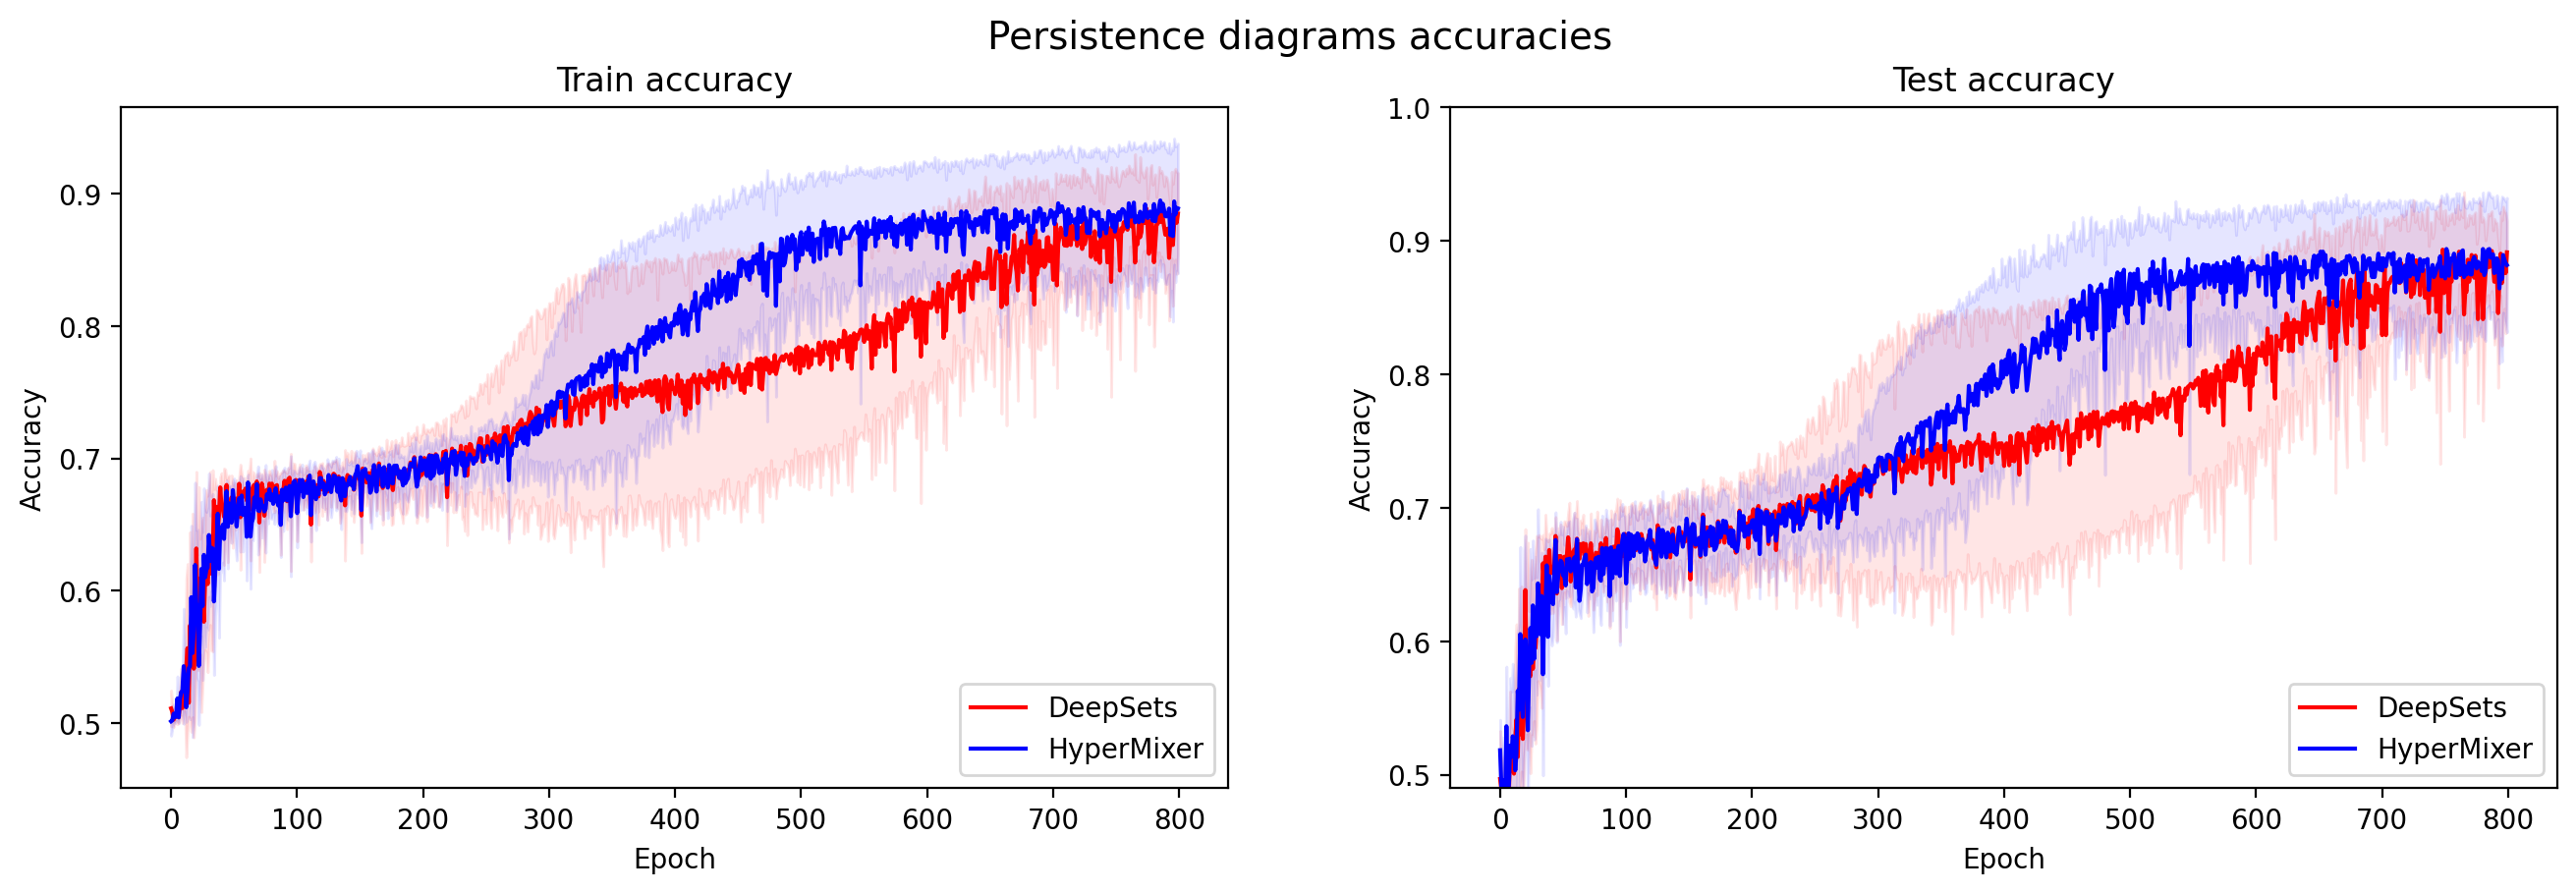

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4.5), dpi=200)
fig.suptitle("Persistence diagrams accuracies", fontsize=14)
ax[0].set_title("Train accuracy")
ax[1].set_ylim(0.49, 1)
ax[0].plot(history[0,:,:,:].mean(axis=0)[:,1], c="r", label="DeepSets")
ax[0].plot(history[1,:,:,:].mean(axis=0)[:,1], c="b", label="HyperMixer")
ax[0].fill_between(x_ds, acc_train_ci1_ds, acc_train_ci2_ds, color="r", alpha=0.1)
ax[0].fill_between(x_hc, acc_train_ci1_hc, acc_train_ci2_hc, color="b", alpha=0.1)
ax[0].legend(loc=4)
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[1].set_title("Test accuracy")
ax[1].set_ylim(0.49, 1)
ax[1].plot(history[0,:,:,:].mean(axis=0)[:,2], c="r", label="DeepSets")
ax[1].plot(history[1,:,:,:].mean(axis=0)[:,2], c="b", label="HyperMixer")
ax[1].fill_between(x_ds, acc_test_ci1_ds, acc_test_ci2_ds, color="r", alpha=0.1)
ax[1].fill_between(x_hc, acc_test_ci1_hc, acc_test_ci2_hc, color="b", alpha=0.1)
ax[1].legend(loc=4)
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
plt.show()

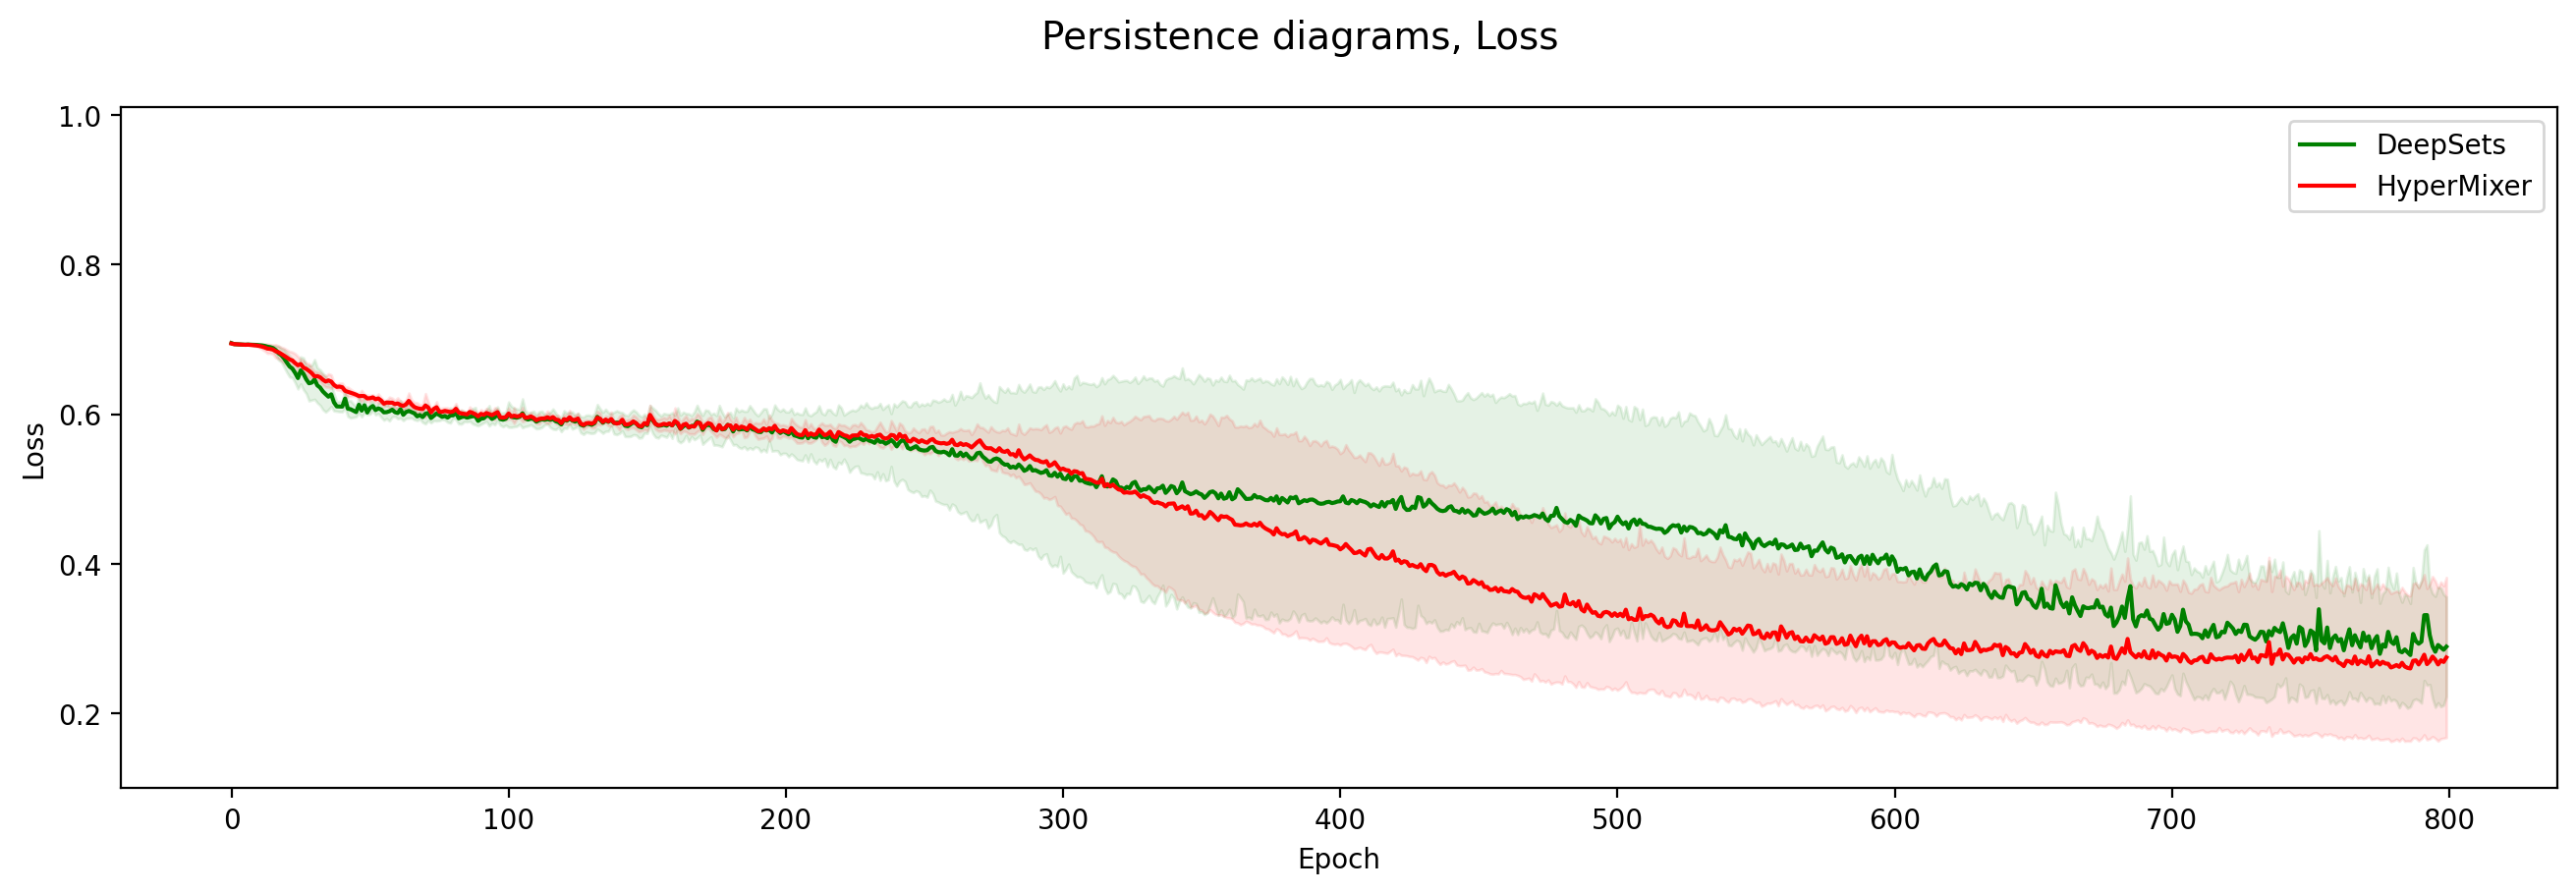

In [27]:
plt.figure(figsize=(16, 4.5), dpi=200)
plt.suptitle("Persistence diagrams, Loss", fontsize=14)
plt.ylim(0.1, 1.01)
plt.plot(history[0,:,:,:].mean(axis=0)[:,0], c="g", label="DeepSets")
plt.fill_between(x_ds, loss_ci1_ds, loss_ci2_ds, color="g", alpha=0.1)
plt.plot(history[1,:,:,:].mean(axis=0)[:,0], c="r", label="HyperMixer")
plt.fill_between(x_hc, loss_ci1_hc, loss_ci2_hc, color="r", alpha=0.1)
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show();

#### Сводная таблица с результатами:

In [28]:
print("\t\t\t\t\tLoss\tTrain\tTest")
print("DeepSets avg results:\t\t\t{:.4f}\t{:.4f}\t{:.4f}".format(*history[0,:,-1,:].mean(axis=0)), sep="\t") # avg loss, avg train acc, avg test acc
print("HyperClassifier avg results:\t\t{:.4f}\t{:.4f}\t{:.4f}".format(*history[1,:,-1,:].mean(axis=0)), sep="\t") # avg loss, avg train acc, avg test acc
print("DeepSets results' std:\t\t\t{:.4f}\t{:.4f}\t{:.4f}".format(*history[0,:,-1,:].std(axis=0)), sep="\t") # avg loss, avg train acc, avg test acc
print("HyperClassifier results' std:\t\t{:.4f}\t{:.4f}\t{:.4f}".format(*history[1,:,-1,:].std(axis=0)), sep="\t") # avg loss, avg train acc, avg test acc
for i in range(5):
    print("DeepSets {} repeat results:\t\t{:.4f}\t{:.4f}\t{:.4f}".format(i+1, *history[0,i,-1,:]), sep="\t")
    print("HyperClassifier {} repeat results:\t{:.4f}\t{:.4f}\t{:.4f}".format(i+1, *history[1,i,-1,:]), sep="\t")

					Loss	Train	Test
DeepSets avg results:			0.2894	0.8851	0.8915
HyperClassifier avg results:		0.2749	0.8890	0.8820
DeepSets results' std:			0.0665	0.0306	0.0235
HyperClassifier results' std:		0.1070	0.0491	0.0504
DeepSets 1 repeat results:		0.3163	0.8712	0.8825
HyperClassifier 1 repeat results:	0.3186	0.8662	0.8700
DeepSets 2 repeat results:		0.3251	0.8700	0.8750
HyperClassifier 2 repeat results:	0.3428	0.8869	0.8875
DeepSets 3 repeat results:		0.3365	0.8681	0.8750
HyperClassifier 3 repeat results:	0.3182	0.8656	0.8475
DeepSets 4 repeat results:		0.3115	0.8700	0.8875
HyperClassifier 4 repeat results:	0.0617	0.9831	0.9750
DeepSets 5 repeat results:		0.1576	0.9463	0.9375
HyperClassifier 5 repeat results:	0.3329	0.8431	0.8300
